In [1]:
import json
with open('hyperparameters/initial_run.json', 'rb') as f:
        params = json.load(f)

In [2]:
params

{'image_size': 256,
 'batch_size': 32,
 'train_size': 0.8,
 'margin': 0.2,
 'squared': False,
 'embedding_size': 256,
 'lr': 0.0001}

In [3]:
from data import get_dataset, get_ELEP_images_and_labels, get_zoo_elephants_images_and_labels
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from collections import Counter
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from collections import Counter

In [4]:
data_dir2 = '/Users/deepakduggirala/Documents/ELPephant/images'
data_dir = '/Users/deepakduggirala/Documents/Elephants-dataset-png'

In [61]:
train_ds, val_ds = get_dataset(get_zoo_elephants_images_and_labels, params, data_dir)

In [62]:
images, labels = next(train_ds.as_numpy_iterator())

In [63]:
Counter(labels)

Counter({b'1002': 11,
         b'1019': 10,
         b'1018': 15,
         b'1012': 7,
         b'1004': 8,
         b'1001': 10,
         b'1000': 3,
         b'1005': 8,
         b'1008': 4,
         b'1020': 6,
         b'1007': 10,
         b'1015': 11,
         b'1021': 9,
         b'1017': 7,
         b'1039': 4,
         b'1040': 4,
         b'1037': 1})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.image.AxesImage at 0x1684b0190>, b'1015')

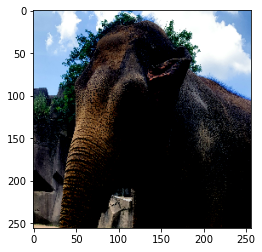

In [7]:
plt.imshow(images[0]), labels[0]

In [4]:
from model import get_model

In [5]:
siamese_model = get_model(params, finetune=True)

In [6]:
siamese_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
Total params: 24,089,344
Trainable params: 524,544
Non-trainable params: 23,564,800
_________________________________________________________________


In [64]:
embeddings = siamese_model(images)

In [65]:
embeddings.shape

TensorShape([128, 256])

In [70]:
embeddings_norm = tf.math.l2_normalize(embeddings, axis=1, epsilon=1e-10)

In [91]:
from triplet_loss import _pairwise_distances, _get_triplet_mask

In [71]:
pairwise_dist = _pairwise_distances(embeddings_norm)

In [72]:
pairwise_dist.numpy()

array([[0.        , 0.9691331 , 0.82634073, ..., 0.6193127 , 0.70013267,
        0.5413159 ],
       [0.9691331 , 0.        , 0.84876305, ..., 1.0026968 , 0.94692683,
        0.99882495],
       [0.82634073, 0.84876305, 0.        , ..., 0.89623076, 0.809446  ,
        0.80576456],
       ...,
       [0.6193127 , 1.0026968 , 0.89623076, ..., 0.        , 0.64580643,
        0.63700217],
       [0.70013267, 0.94692683, 0.809446  , ..., 0.64580643, 0.        ,
        0.6911984 ],
       [0.5413159 , 0.99882495, 0.80576456, ..., 0.63700217, 0.6911984 ,
        0.        ]], dtype=float32)

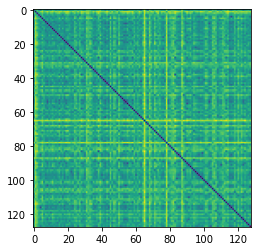

In [73]:
plt.imshow(pairwise_dist.numpy())

In [74]:
anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)

In [75]:
anchor_positive_dist.shape

TensorShape([128, 128, 1])

In [76]:
anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)

In [77]:
anchor_negative_dist.shape

TensorShape([128, 1, 128])

In [78]:
margin = 0.5

In [81]:
triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

In [82]:
triplet_loss.shape

TensorShape([128, 128, 128])

In [92]:
mask = _get_triplet_mask(labels)

In [98]:
mask = tf.cast(mask, dtype=tf.float32)
triplet_loss = tf.multiply(mask, triplet_loss)

In [100]:
triplet_loss = tf.maximum(triplet_loss, 0.0)

In [101]:
valid_triplets = tf.cast(tf.greater(triplet_loss, 1e-16), dtype=tf.float32)
num_positive_triplets = tf.reduce_sum(valid_triplets)
num_valid_triplets = tf.reduce_sum(mask)
fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

In [102]:
fraction_positive_triplets

<tf.Tensor: shape=(), dtype=float32, numpy=0.98275805>

In [15]:
tf.zeros((1,))

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>

In [36]:
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from triplet_loss import batch_all_triplet_loss

In [40]:
class SiameseModel(Model):
    def __init__(self, params, finetune):
        super().__init__()
        self.params = params
        self.finetune = finetune
        self.siamese_network = get_model(params, finetune)
        self.loss_tracker = metrics.Mean(name="loss")
        self.custom_loss = batch_all_triplet_loss

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        images, labels = data
        print('train', images.shape, labels.shape)
        with tf.GradientTape() as tape:
            loss = self._compute_loss(images, labels)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )
        a
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()} 
    
    def test_step(self, data):
        images, labels = data
        print('test', images.shape, labels.shape)
        loss = self._compute_loss(images, labels)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    def _compute_loss(self, images, labels):
        embeddings = self.siamese_network(images)
        embeddings = tf.math.l2_normalize(embeddings, axis=1, epsilon=1e-10)
        return self.custom_loss(labels, embeddings, self.params['margin'], self.params['squared'])

In [123]:
siamese_model = SiameseModel(params, True)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))

In [42]:
siamese_model.fit(train_ds.take(1),
                  epochs=1,
                  validation_data=val_ds.take(1))

train (None, 256, 256, 3) (None,)
train (None, 256, 256, 3) (None,)
1/1 [==============================] - 17s 17s/step - loss: 0.1205 - val_loss: 0.1886


In [124]:
input_shape=(None, params['image_size'], params['image_size'], 3)
siamese_model.compute_output_shape(input_shape=input_shape)


TensorShape([None, 256])

In [112]:
import math

In [116]:
N=2076
train_size = int(N * params['train_size'])
STEPS_PER_EPOCH = train_size / params['batch_size']

In [117]:
int(10 * STEPS_PER_EPOCH)

129

In [126]:
siamese_model.summary()

Model: "siamese_model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_9 (Functional)        (None, 256)               24089344  
                                                                 
Total params: 24,089,346
Trainable params: 524,544
Non-trainable params: 23,564,802
_________________________________________________________________


In [ ]:
[i.shape for i in siamese_model.trainable_weights]

In [128]:
model = get_model(params, True)

In [129]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_10 (Dense)            (None, 256)               524544    
                                                                 
Total params: 24,089,344
Trainable params: 524,544
Non-trainable params: 23,564,800
_________________________________________________________________


In [13]:
base_model = tf.keras.applications.ResNet50V2(include_top=False,
                                                  weights="imagenet",
                                                  input_shape=(params['image_size'], params['image_size'], 3),
                                                  pooling='avg')
# base_model.trainable = False

trainable = False
for layer in base_model.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [14]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [2]:
import tensorflow as tf

In [19]:
cache_files={
      'train': 'ELP_train.cache',
      'val': 'ELP_val.cache'
    }

N=10
AUTOTUNE = tf.data.experimental.AUTOTUNE
dataset = tf.data.Dataset.range(N)
dataset = dataset.shuffle(buffer_size=N)

train_ds = dataset.take(round(N * 0.6))
val_ds = dataset.skip(round(N * 0.6))

if cache_files:
    train_ds = train_ds.cache(cache_files['train'])
    val_ds   = val_ds.cache(cache_files['val'])
else:
    train_ds = train_ds.cache()
    val_ds   = val_ds.cache()

train_ds = train_ds.shuffle(buffer_size=N, reshuffle_each_iteration=True)
val_ds   = val_ds.shuffle(buffer_size=N, reshuffle_each_iteration=True)


train_ds = train_ds.batch(3).prefetch(AUTOTUNE)
val_ds = val_ds.batch(4).prefetch(AUTOTUNE)

In [23]:
list(train_ds.as_numpy_iterator()), list(val_ds.as_numpy_iterator())

([array([0, 1, 5]), array([4, 9, 6])], [array([9, 3, 4, 7])])